# Intro

`-` 자연어 데이터를 시각화하여 중요한 키워드를 도출하고 어느 부분에서 개선이 필요한지 인사이트를 도출

`-` 이를 통해, 후기 교육생들을 위한 코칭 프로세스 개선 방안 마련

# 0. import

In [13]:
# | code-fold : true
import pandas as pd    # pandas 데이터프레임을 생성/편집하기 위해 사용 합니다.
import matplotlib.pyplot as plt   
from wordcloud import WordCloud    
from collections import Counter   
import re    
from PIL import Image 
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

from mecab import MeCab
mecab = MeCab()

***

# 1. 데이터 로드

`-` 사전에 전처리를 마친 데이터를 불러옴

In [14]:
data = pd.read_csv("전처리data.csv").loc[:,["문의유형","한글자제거"]] ## 전처리 data
result = pd.read_csv("전처리tidydata.csv")

# 2. 명사 추출

`-` 필터품사

`-` 코드와 웹에선 영어 단어가 많으므로 외국어(`SL`)도 보존

`-` 명사는 일반 명사(`NNG`)와 고유명사(`NNP`)만 사용

In [15]:
f_col =["NNG","SL","NNP"]
title = result["문의유형"].unique().tolist()

In [16]:
result2 = pd.DataFrame()

for i in range(len(title)) :
    temp = result.loc[result.문의유형 == title[i], "word"]
    temp = " ".join([str(i) for i in temp])
    temp = [i[0] for i in mecab.pos(temp) if i[1] in f_col]
    temp = pd.DataFrame({"word": temp})
    temp["문의유형"] = title[i]
    result2 = pd.concat([result2,temp], axis = 0)

# 3. 한글자 단어 제거

In [17]:
result2 = result2.loc[map(lambda x : len(x) >=2, result2.word), :]

# 4. 전체 단어에서 불용어 판단

`-` 의외로 출현 빈도수가 1회인 단어들은 `mnist`와 같은 중요한 데이터셋의 정보를 담고 있음

`-` 그에 반해 빈도수가 많은 단어들은 문서를 자동 분류하기에 적합한 단어라고 보기 어렵다(딱히 차별성이 없어보임..)

`-` 따라서 전체 단어에서 50회 이상 출현한 단어를 불용어로 판단

In [18]:
result2.groupby("word",as_index = False)[["word"]].\
                    value_counts().sort_values("count",ascending=False).head(10)

,word,count
6198,사용,237
7490,진행,217
7840,파일,212
5889,문제,197
5565,데이터,192
6574,실행,186
8104,확인,180
7134,입력,164
6567,실습,146
6087,부분,143


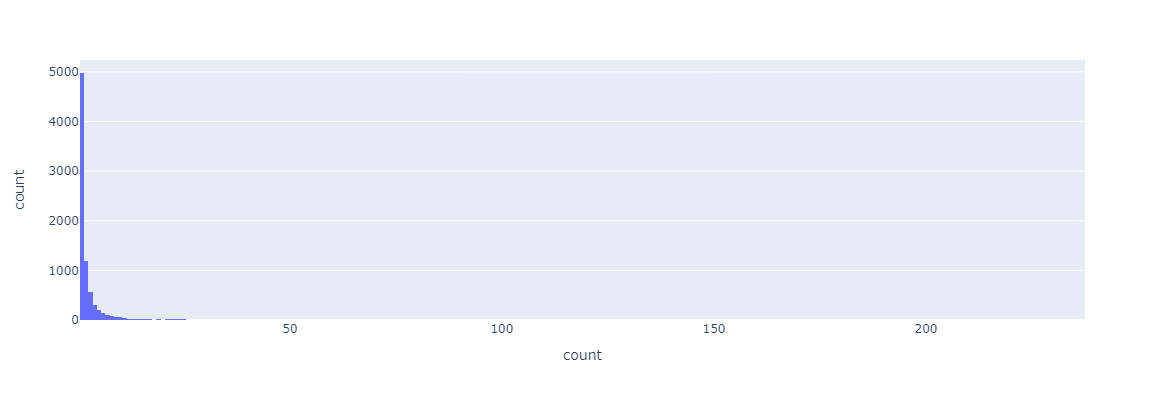

In [19]:
result2.groupby("word",as_index = False)[["word"]].\
                                value_counts().plot(kind = "hist", backend = "plotly",
                                                    x= "count", height = 400)

In [20]:
temp = result2.groupby("word",as_index = False)[["word"]].value_counts()
temp = temp.loc[[i > 50 for i in temp["count"]],:]
stop_word = temp["word"].tolist()

# 5. 문의 유형별 단어 카운트

In [21]:
c_table = result2.groupby(["문의유형"], as_index = False)[["word"]].value_counts()
c_table = c_table.loc[[i not in stop_word for i in c_table["word"]], :]

# 6. 문의 유형별 단어 분포 확인

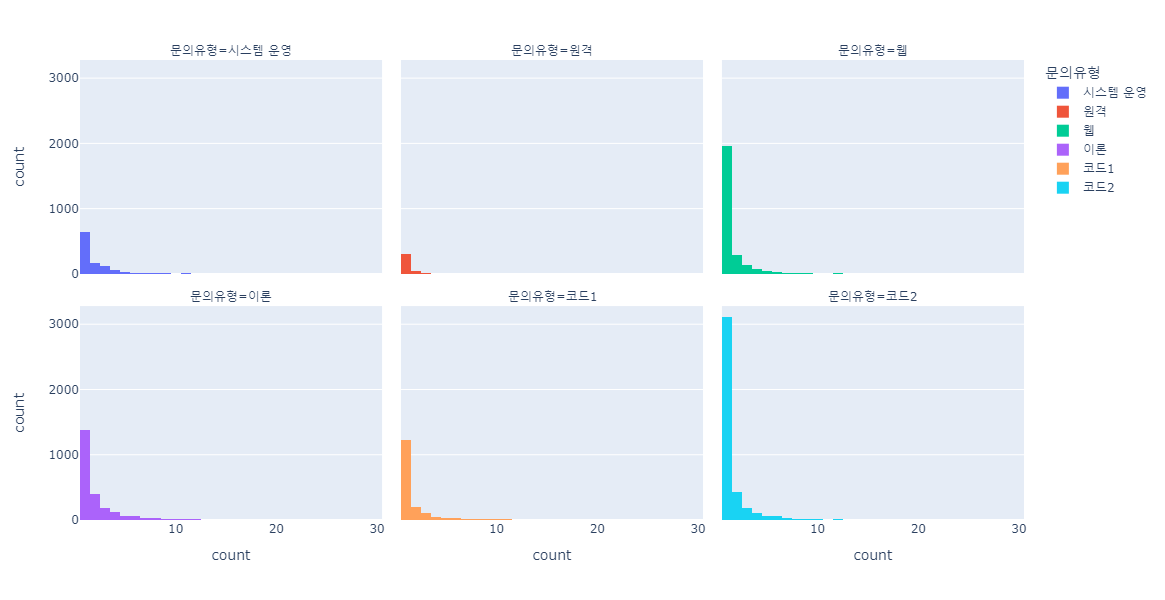

In [22]:
c_table.plot(x = "count", kind = "hist",
              backend = "plotly", color = "문의유형",
              facet_col = "문의유형", facet_col_wrap = 3,width = 800, height = 600)

# 7. 문의 유형별 워드클라우드 시각화

In [23]:
for i in range(len(title)) : 
    temp_word_count = c_table.loc[c_table.문의유형 == title[i], ["word","count"]].\
                            set_index("word").to_dict()["count"]
    exec(f'''temp_cloud{i} = WordCloud(
                                background_color  = "white",
                                font_path = "projects/posts/mini projects/AIVLE/malgun.ttf",
                                ).generate_from_frequencies(temp_word_count)''')


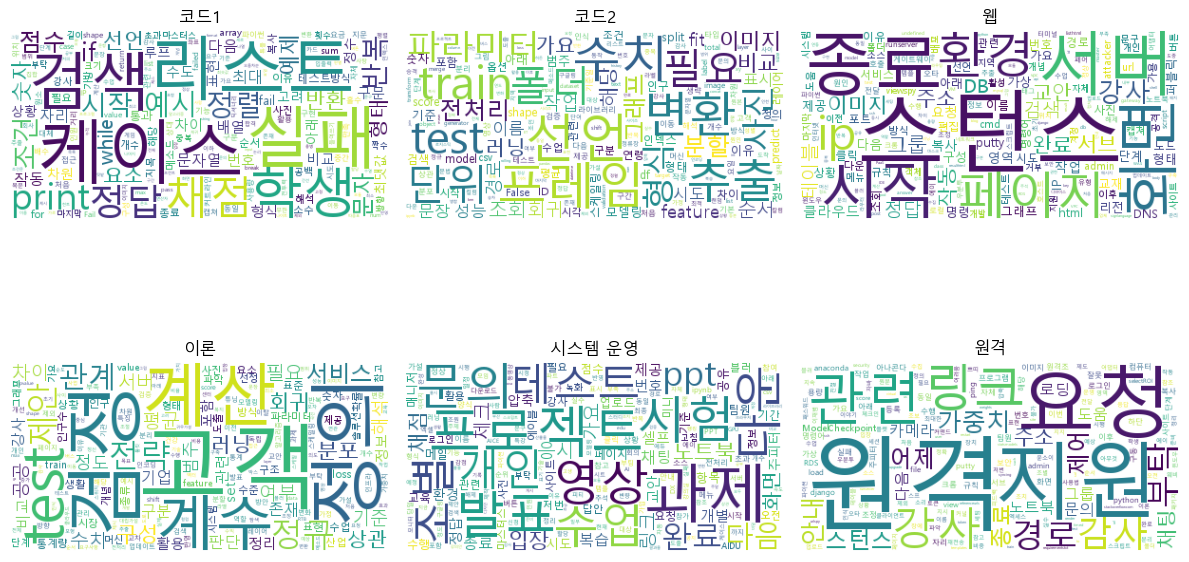

In [24]:
fig, axes = plt.subplots(2,3, figsize = (12, 8))

temp_cloud = [[temp_cloud0,temp_cloud1, temp_cloud2],
              [temp_cloud3,temp_cloud4, temp_cloud5]]

title2 = [['코드1', '코드2', '웹'],
           ['이론', '시스템 운영', '원격']]

for i in range(2) :
    for j in range(3) : 
        axes[i][j].imshow(temp_cloud[i][j])
        axes[i][j].axis("off")
        axes[i][j].set_title(title2[i][j])

fig.tight_layout()

# 8. insight

`1` 코드 1에서는 리스트, 케이스, 검색, 실패 등 초반부에 파이썬에 대한 개념이 잘 잡히지 않았고 코딩 마스터즈 관련 질문도 많이 보인다.

*  초반부에 파이선에 대한 개념 위주의 실습을 더욱 구체화한다면, 후기 에이블러들이 학습하는데 도움이 될 것 같다.

`2` 코드 2에서는 모델링 관련 문의가 많다.

* 수업 중 느꼈지만, 먼가 머신러닝, 딥러닝 모델 학습 기간이 너무 짧은 것 같다. 시간적인 부분에 대한 개선이 필요하다.

`3` 웹에서는 페이지 작동과 환경 구성, 서버 관련 문의가 많다.

* 특히 스턴, 종료라는 단어가 눈에 띄는데 어감상 불편한걸 보니 전 기수에서 서버관련 이슈가 많았나보다.

`4`  이론에서는 검정 정의, 분포, 계수 등에 질문이 많아 보인다. 

* 이론이 안잡히면 코딩하기가 어렵다. 뭔가 이론을 한방에 요약해주는 한방 pdf 자료를 제공해주면 에이블러들이 학습하는데 도움이 될 것 같다.

`5` 시스템 운영, 원격

* 시스템 운영에서는 과제, 발표, 프로젝트, 시험 등 학습 외적인 질문이 많다.

* 이 부분은 KT 관계자들과 이야기할 필요가 있어보인다.

`6` 원격에서는 에이블러분들의 요청들을 볼 수 있었다.

* 그리고 감사라는 단어가 상위 빈도로 보이는데, 튜터님들과 에이블러들 사이에 어떤 돈독함을 잘 보여주는 것 같다.